# Capital Cost of Compression

- [Data Preparation](#data-preparation)
    - [Imports](#imports)
    - [Auxiliary Functions](#auxiliary-functions)
    - [Data Reading](#data-reading)
    - [Variables](#variables)
- [Analysis](#analysis)
    - [CECPI Index Time Series](#cecpi-index-time-series)
    - [Compression Power Requirement & Carbon Capture Percentage](#compression-power-requirement--carbon-capture-percentage)
    - [Power Requirement](#power-requirement)
    - [Capital Cost of Compression](#capital-cost-of-compression)
    - [Annual Compression Cost](#annual-compression-cost)
    - [Sensitivity Analysis](#sensitivity-analysis)

## Data Preparation

### Imports

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator, ScalarFormatter, FuncFormatter

from scipy.stats import linregress

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from scipy.optimize import curve_fit

import requests
from io import BytesIO

### Auxiliary Functions

In [26]:
def calculate_compression_power(
    kappa,
    specific_heat_cp,
    mass_flow_rate,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    compression_ratio,
):
    """
    Calculates the isentropic compression power requirement per stage.
    """
    # Coefficient of Adiabatic Expansion
    specific_heat_ratio = specific_heat_cp / compression_ratio
    co2_specific_heat_ratio = (specific_heat_ratio - 1) / specific_heat_ratio

    # Calculate the power [kW]
    stage_power = (
        kappa
        * (
            mass_flow_rate
            * compression_ratio
            * gas_constant
            * inlet_temp
            / (co2_specific_heat_ratio * molar_mass * isentropic_efficiency)
        )
        * (pressure_ratio_per_stage**co2_specific_heat_ratio - 1)
    )

    return specific_heat_ratio, stage_power


def calculate_power_requirement(
    stage_k,
    compression_ratio_stage,
    corrected_carbon_emissions,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    kappa,
):
    """
    Calculates the total power requirement for a multi-stage compression process.
    """
    power_requirement = 0.0

    for k, compression_ratio in zip(stage_k, compression_ratio_stage):
        # Calculate the power for the current stage
        power_per_stage = (
            (
                (corrected_carbon_emissions / 365)
                * compression_ratio
                * gas_constant
                * inlet_temp
                / (molar_mass * isentropic_efficiency)
            )
            * (k / (k - 1))
            * (pressure_ratio_per_stage ** ((k - 1) / k) - 1)
        )

        # Totals the power
        power_requirement += power_per_stage

    power_requirement *= kappa

    return power_requirement


def calculate_capital_costs(
    df,
    initial_cost_ratio,
    average_growth_ratio,
    kappa,
    corrected_carbon_emissions,
    power_requirement,
    pressure_ratio,
    c1=0.13 * (10**6),
    c2=1.4 * (10**6),
):
    """
    Calculates the total capital cost and the capital cost per power for a
    multi-stage compression plant, applying a temporal cost correction.
    """

    # Plant Cost Index
    temporal_cost_correction = np.zeros(len(df.index))
    for idx in range(len(temporal_cost_correction)):
        if idx == 0:
            temporal_cost_correction[0] = initial_cost_ratio
        else:
            temporal_cost_correction[idx] = (
                temporal_cost_correction[idx - 1] * average_growth_ratio
            )

    # Capital Cost ($)

    # Calculate v parameter
    v = (
        kappa
        * (corrected_carbon_emissions / 365)
        / (np.ceil(power_requirement / 60000))
    )

    # Calculate the base capital cost
    capital_cost = (
        kappa
        * (corrected_carbon_emissions / 365)
        * ((c1 / (v**0.71)) + (c2 * np.log(pressure_ratio) / (v**0.6)))
    )

    # Apply temporal correction for each year
    for idx, year in enumerate(df.index):
        capital_cost[capital_cost.index == year] *= temporal_cost_correction[idx]

    # Capital Cost of Compression ($/kW)
    capital_cost_per_power = capital_cost / power_requirement

    return capital_cost, capital_cost_per_power


def transform_dataframe(df, value_name):
    """
    Performs transformations on annual cost Dataframes.
    """
    df = df.reset_index()
    df = df.melt(id_vars=["Years"], var_name="Original Column", value_name="Value")
    df[["Company", "Model"]] = df["Original Column"].str.split(" - ", expand=True)
    df.drop(columns=["Original Column"], inplace=True)
    df.rename(columns={"Value": value_name}, inplace=True)
    return df


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_values, x_lim, title, leg_loc="upper right", x_multiplelocator=2):
    y_min, y_max = min(y_values), max(y_values)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    # ax.grid(color="w", axis="y")
    ax.grid(axis="y", alpha=0.1)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)


def plot_dataframes(df, list_of_companies, plot_config):
    """
    Generates a multi-subplot figure based on input DataFrame and a list of companies.
    """
    fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
    axs = axs.flatten()

    for company_id, company_name in enumerate(list_of_companies):
        ax = axs[company_id]
        X = df.index.values
        y_values = np.array([])  # Initialize with an empty array

        for plot_type, color in plot_config["colors"].items():
            column_name = f"{company_name} - {plot_type}"
            data = df.loc[:, column_name].values
            y_values = np.concatenate((y_values, data))
            ax.plot(X, data, "-o", color=color, label=plot_type)

        config_plot(
            ax,
            y_values,
            x_lim=[2025 - 0.5, 2031 - 0.5],
            title=company_name,
            leg_loc=plot_config["leg_loc"],
            x_multiplelocator=1,
        )

        if company_id in [0, 3]:
            ax.set_ylabel(plot_config["ylabel"])

        if company_id >= 3:
            ax.set_xlabel("$t \\, [year]$")

    fig.savefig(plot_config["save_path"], dpi=600, bbox_inches="tight")

### Data Reading

In [27]:
# URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Forecast%20(MtCO2e).xlsx"
# response = requests.get(URL)

# df = pd.read_excel(BytesIO(response.content), engine="openpyxl")
df = pd.read_excel("../data/Forecast (MtCO2e).xlsx")
df_b = pd.read_excel("../data/Forecast - Benchmark.xlsx")

df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("Years", inplace=True)

df_b.drop(columns="Unnamed: 0", inplace=True)
df_b.set_index("Years", inplace=True)
df_b = df_b.loc[df_b.index != 2024, :]

for column_name in df_b.columns:
    df_b.rename(columns={column_name: column_name + " - GBM"}, inplace=True)

list_of_companies = ["A-1", "C-1", "C-2", "P-1", "S-1", "S-2"]

display(df)
display(df_b)

,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,23.632865,18.060261,23.264298,13.513428,13.340975,13.302679,8.940516,9.801581,8.801084,2.283988,2.074743,2.248368,1.579306,1.519020,1.554676,1.341908,1.252185,1.320980
2026,23.632865,17.756772,22.901478,13.513428,13.317894,13.095216,8.940516,9.772826,8.663826,2.283988,1.921093,2.213303,1.579306,1.519730,1.530430,1.341908,1.242492,1.300379
2027,23.632865,17.540634,22.544317,13.513428,13.317618,12.890989,8.940516,9.788235,8.528709,2.283988,1.776351,2.178785,1.579306,1.519925,1.506562,1.341908,1.239475,1.280099
2028,23.632865,17.448469,22.192726,13.513428,13.319519,12.689947,8.940516,9.823698,8.395699,2.283988,1.657053,2.144806,1.579306,1.519972,1.483066,1.341908,1.238880,1.260135
2029,23.632865,17.423024,21.846618,13.513428,13.319376,12.492040,8.940516,9.856964,8.264763,2.283988,1.569028,2.111357,1.579306,1.519983,1.459937,1.341908,1.238803,1.240482
2030,23.632865,17.418340,21.505907,13.513428,13.318683,12.297220,8.940516,9.878516,8.135870,2.283988,1.510201,2.078429,1.579306,1.519985,1.437168,1.341908,1.238796,1.221136


,P-1 - GBM,C-1 - GBM,S-2 - GBM,C-2 - GBM,S-1 - GBM,A-1 - GBM
Years,,,,,,
2025,2.188742,1.513447,8.567684,12.949899,22.647341,1.285949
2026,2.097468,1.450334,8.210399,12.409870,21.702915,1.232323
2027,2.010001,1.389853,7.868014,11.892361,20.797873,1.180933
2028,1.926181,1.331894,7.539907,11.396433,19.930572,1.131686
2029,1.845857,1.276352,7.225482,10.921185,19.099439,1.084494
2030,1.768882,1.223127,6.924169,10.465756,18.302966,1.039269


### Variables

In [28]:
inlet_pressure = 0.1  # Initial Pressure [MPa]
outlet_pressure = 7.38  # Compressor Outlet Pressure (Rename, now it's final) Po
num_stages = 4  # Number of Stages
molar_mass = 44.01  # Molar Mass of CO2 [kg/kmol]
gas_constant = 8.314  # Ideal Gas Constant [kJ/kmol*K]
inlet_temp = 313.15  # Inlet Temperature [K]
isentropic_efficiency = 0.82  # Compressor Isentropic Efficiency
mass_flow_rate = 25000  # CO2 Mass Flow Rate
temp_variation = 356  # Temperature Variation During Compression

compression_ratio_stage = [0.995, 0.986, 0.959, 0.875]  # Compression Ratio per Stage

# Energy Cost
energy_price = 0.0815  # Energy Price
capacity_factor = 0.8  # Capacity Factor

# Capital Cost
capital_recovery_factor = 0.1275  # Capital Recovery Factor

# Operational & Maintenance Cost
oem_maintenance_factor = 0.05  # OEM Maintenance Operating Factor

In [29]:
COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "Benchmark": mcolors.CSS4_COLORS["darkviolet"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
    "Fit": mcolors.CSS4_COLORS["steelblue"],
    "Pred": mcolors.CSS4_COLORS["indigo"],
    0: ["#FF7F0E", "#FFB347", "#CC5500"],
    1: ["#8A2BE2", "#BA55D3"],
    2: ["#8B4513", "#8B4513"],
}

## Analysis

### CECPI Index Time Series

Time serie of the CECPI index

R2_full = 0.9505
CEPCI_full = 0.0348


,Year,CEPCI
0,2026,717.570661
1,2027,727.945190
2,2028,738.319720
3,2029,748.694249
4,2030,759.068779


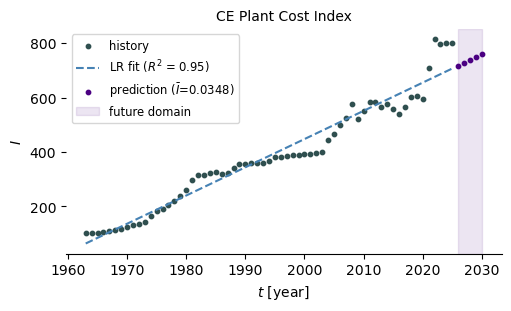

In [30]:
# Available Measurement
years = np.arange(1963, 2026, dtype=int)

# Index Values Over Time From 1970 to 2025
msi = np.array([
       102.4, 103.3, 104.2, 107.2, 109.7, 113.7, 119. , 125.7, 132.3,
       137.2, 144.1, 165.4, 182.4, 192.1, 204.1, 218.8, 238.7, 261.2,
       297. , 314. , 317. , 322.7, 325.3, 318.4, 323.8, 342.5, 355.4,
       357.6, 361.3, 358.2, 359.2, 368.1, 381.1, 381.7, 386.5, 389.5,
       390.6, 394.1, 394.3, 395.6, 402. , 444.2, 468.2, 499.6, 525.4,
       575.4, 521.9, 550.8, 585.7, 584.6, 567.3, 576.1, 556.8, 541.7,
       567.5, 603.1, 607.5, 596.2, 708.8, 816. , 797.9, 799.8, 800. ])

nf = 6  # future years
future = np.arange(years[-1] + 1, years[-1] + nf)

s_full, i_full, r_full, *_ = linregress(years, msi)
print(f"R2_full = {r_full**2:.4f}")

agr_full = (msi[1:] / msi[:-1]).mean() - 1
print(f"CEPCI_full = {agr_full:.4f}")

r = lambda t: s_full * t + i_full

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)

ax.scatter(years, msi, s=10, c=COLORS["History"], label="history")
ax.plot(
    years, r(years), "--", c=COLORS["Fit"], label=f"LR fit ($R^2$ = {r_full**2:.2f})"
)
ax.scatter(
    future,
    r(future),
    s=10,
    c=COLORS["Pred"],
    label="prediction (" + r"$\bar{I}$" + f"={agr_full:.4f})",
)

# ax.axvspan(pre[0], post[0], alpha=0.1, color="#ffbbad")
# ax.axvspan(post[0], post[-1], alpha=0.1, color="#bbddad")
ax.axvspan(
    future[0], future[-1], alpha=0.1, color=COLORS["Pred"], label="future domain"
)

ax.set_xlabel("$t$ [year]", fontsize=10)
ax.set_ylabel("$I$", fontsize=10)
ax.set_title("CE Plant Cost Index", fontsize=10)

ax.legend(fontsize="small")
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("../results/costs/cepci.png", dpi=600, bbox_inches="tight")

pd.DataFrame({"Year": future, "CEPCI": r(future)})#.to_latex()

MAPE validação (últimos 5 anos do recorte):
  Linear: 0.2038
  Exp×Senoide: 0.2069

Parâmetros do modelo exp×senoide (t = ano - 2005):
  A     = 516.195
  alpha = 0.0101913
  beta  = 0.0337857
  omega = 1.17158 (rad/ano)  => período ≈ 5.36 anos
  phi   = -1.51351

Previsões 2025–2030:
 Year  Linear  ExpSin
 2025  635.72  634.46
 2026  641.94  620.15
 2027  648.16  629.23
 2028  654.38  659.06
 2029  660.60  681.40
 2030  666.82  676.74


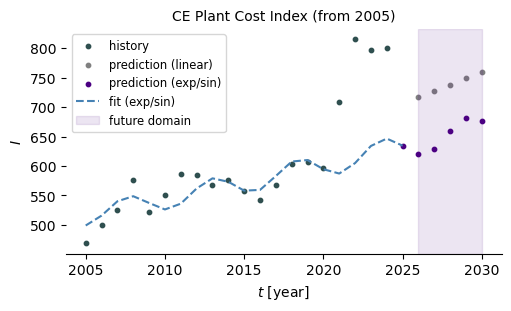

In [31]:
# Clipping from 2005
START_YEAR = 2005
mask = years >= START_YEAR
years_recent = years[mask]
y_recent = msi[mask]

# Relative time variable (t=0 in 2005)
t_recent = years_recent - START_YEAR

# Training/validation division (last 5 years of the cut)
VAL_LAST_N_YEARS = 5
val_n = min(VAL_LAST_N_YEARS, max(2, len(years_recent) // 4))
train_end = len(years_recent) - val_n

t_train, y_train = t_recent[:train_end], y_recent[:train_end]
t_val, y_val = t_recent[train_end:], y_recent[train_end:]
years_train, years_val = years_recent[:train_end], years_recent[train_end:]

# Linear Model
lin = LinearRegression()
lin.fit(t_train.reshape(-1, 1), y_train)
y_val_lin = lin.predict(t_val.reshape(-1, 1))
mape_lin = mean_absolute_percentage_error(y_val, y_val_lin)

# Linear forecasts 2025–2030
FORECAST_YEARS = np.arange(2025, 2031)
t_future = FORECAST_YEARS - START_YEAR
y_fore_lin = lin.predict(t_future.reshape(-1, 1))


# Exponential × Sinusoidal Model
def exp_sin_model(t, A, alpha, beta, omega, phi):
    return A * np.exp(alpha * t) * (1.0 + beta * np.sin(omega * t + phi))


# Initial estimate
A0 = y_train[0]
alpha0 = (np.log(y_train[-1]) - np.log(y_train[0])) / max(
    1e-6, (t_train[-1] - t_train[0])
)
beta0 = 0.1
omega0 = 2 * np.pi / 15  # ciclo ~15 anos
phi0 = 0.0
p0 = [A0, alpha0, beta0, omega0, phi0]

popt, _ = curve_fit(exp_sin_model, t_train, y_train, p0=p0, maxfev=20000)
y_val_expsin = exp_sin_model(t_val, *popt)
mape_expsin = mean_absolute_percentage_error(y_val, y_val_expsin)

# Exponential-sinusoidal forecasts 2025–2030
y_fit_all_expsin = exp_sin_model(t_recent, *popt)
y_fore_expsin = exp_sin_model(t_future, *popt)

# Numerical results
print("MAPE validação (últimos {} anos do recorte):".format(val_n))
print("  Linear: {:.4f}".format(mape_lin))
print("  Exp×Senoide: {:.4f}".format(mape_expsin))

print("\nParâmetros do modelo exp×senoide (t = ano - 2005):")
A, alpha, beta, omega, phi = popt
print(f"  A     = {A:.6g}")
print(f"  alpha = {alpha:.6g}")
print(f"  beta  = {beta:.6g}")
print(f"  omega = {omega:.6g} (rad/ano)  => período ≈ {2*np.pi/omega:.2f} anos")
print(f"  phi   = {phi:.6g}")

out = pd.DataFrame(
    {
        "Year": FORECAST_YEARS,
        "Linear": np.round(y_fore_lin, 2),
        "ExpSin": np.round(y_fore_expsin, 2),
    }
)
print("\nPrevisões 2025–2030:")
print(out.to_string(index=False))

# Plots
years_all = np.arange(START_YEAR, 2031)
t_all = years_all - START_YEAR
y_fit_lin_all = lin.predict(t_all.reshape(-1, 1))

# plt.figure(figsize=(12,6))
# plt.plot(years_recent, y_recent, "ko-", label="Observado (2005–2024)")
# plt.plot(years_all, y_fit_lin_all, "r-", label="Linear (ajuste+previsão)")
# plt.plot(years_all, exp_sin_model(t_all, *popt), "b-", label="Exp×Senoide (ajuste+previsão)")

# plt.axvspan(2025, 2030, color="gray", alpha=0.1, label="Janela de previsão")
# plt.xlabel("Ano")
# plt.ylabel("CEPCI")
# plt.title("CEPCI (2005–2030) — Modelos Linear e Exponencial×Senoidal")
# plt.legend()
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)

ax.scatter(years_recent[:-1], y_recent[:-1], s=10, c=COLORS["History"], label="history")
ax.scatter(future, r(future), s=10, c="gray", label="prediction (linear)")
ax.scatter(
    years_all[20:],
    exp_sin_model(t_all, *popt)[20:],
    s=10,
    c=COLORS["Pred"],
    label="prediction (exp/sin)",
)
ax.plot(
    years_all[:21],
    exp_sin_model(t_all, *popt)[:21],
    ls="--",
    c=COLORS["Fit"],
    label="fit (exp/sin)",
)

ax.axvspan(
    future[0], future[-1], alpha=0.1, color=COLORS["Pred"], label="future domain"
)

ax.set_xlabel("$t$ [year]", fontsize=10)
ax.set_ylabel("$I$", fontsize=10)
ax.set_title("CE Plant Cost Index (from 2005)", fontsize=10)

ax.legend(fontsize="small")
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("../results/costs/cepci2.png", dpi=600, bbox_inches="tight")

### Compression Power Requirement & Carbon Capture Percentage

In [32]:
kappa = 1000 / (24 * 3600)
pressure_ratio = outlet_pressure / inlet_pressure
pressure_ratio_per_stage = pressure_ratio ** (1 / num_stages)
specific_heat_cv = (
    13.946
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / 44.01
specific_heat_cp = (
    22.26
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / (44.01 * specific_heat_cv)

# Compression Power Requirement

stage_k = []
stage_power = []
for compression_ratio in compression_ratio_stage:
    k, power = calculate_compression_power(
        kappa,
        specific_heat_cp,
        mass_flow_rate,
        gas_constant,
        inlet_temp,
        molar_mass,
        isentropic_efficiency,
        pressure_ratio_per_stage,
        compression_ratio=compression_ratio,
    )
    stage_k.append(k)
    stage_power.append(power)

# Convertion to tCO2e

df = df * 1e6
df_b = df_b * 1e6

# Carbon Capture Percentage

corrected_carbon_emissions = df.copy()
corrected_carbon_emissions = corrected_carbon_emissions * 0.76
display(corrected_carbon_emissions.round(0).astype(int))

corrected_carbon_emissions_b = df_b.copy()
corrected_carbon_emissions_b = corrected_carbon_emissions_b * 0.76

,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,17960978,13725798,17680866,10270205,10139141,10110036,6794792,7449201,6688824,1735831,1576805,1708759,1200273,1154455,1181554,1019850,951660,1003945
2026,17960978,13495147,17405123,10270205,10121600,9952364,6794792,7427348,6584508,1735831,1460031,1682110,1200273,1154995,1163127,1019850,944294,988288
2027,17960978,13330882,17133681,10270205,10121390,9797152,6794792,7439059,6481819,1735831,1350027,1655877,1200273,1155143,1144987,1019850,942001,972875
2028,17960978,13260836,16866471,10270205,10122834,9644360,6794792,7466011,6380731,1735831,1259360,1630053,1200273,1155179,1127130,1019850,941549,957702
2029,17960978,13241498,16603429,10270205,10122726,9493950,6794792,7491293,6281220,1735831,1192461,1604631,1200273,1155187,1109552,1019850,941490,942767
2030,17960978,13237938,16344490,10270205,10122199,9345887,6794792,7507672,6183261,1735831,1147753,1579606,1200273,1155188,1092248,1019850,941485,928064


### Power Requirement

,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,192947,147451,189938,110329,108921,108608,72994,80024,71855,18647,16939,18356,12894,12402,12693,10956,10223,10785
2026,192947,144973,186976,110329,108732,106914,72994,79789,70735,18647,15684,18070,12894,12408,12495,10956,10144,10617
2027,192947,143208,184060,110329,108730,105247,72994,79915,69631,18647,14503,17788,12894,12409,12300,10956,10120,10451
2028,192947,142456,181189,110329,108745,103605,72994,80204,68546,18647,13529,17511,12894,12410,12108,10956,10115,10288
2029,192947,142248,178364,110329,108744,101990,72994,80476,67477,18647,12810,17238,12894,12410,11919,10956,10114,10128
2030,192947,142210,175582,110329,108739,100399,72994,80652,66424,18647,12330,16969,12894,12410,11734,10956,10114,9970


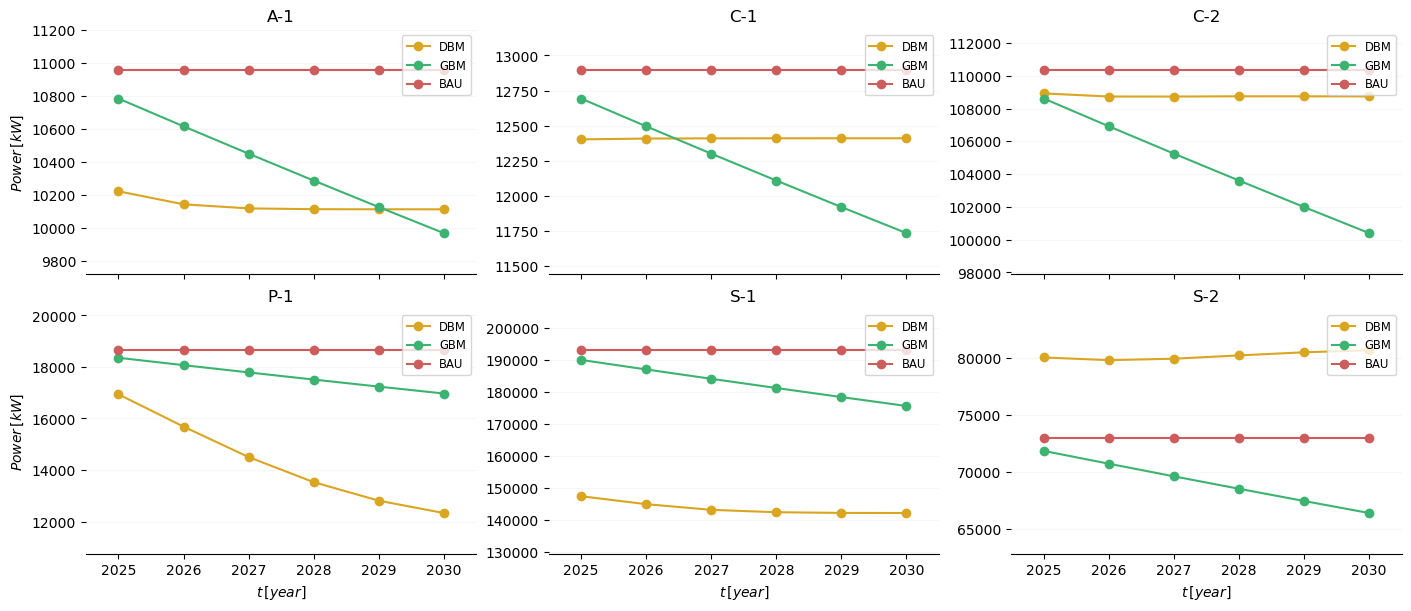

In [33]:
# Total Power Requirement [kW]

power_requirement = calculate_power_requirement(
    stage_k,
    compression_ratio_stage,
    corrected_carbon_emissions,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    kappa,
)
display(power_requirement.round(0).astype(int))

power_requirement_b = calculate_power_requirement(
    stage_k,
    compression_ratio_stage,
    corrected_carbon_emissions_b,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    kappa,
)

# Plot

plot_power = {
    "ylabel": "$Power \\, [kW]$",
    "leg_loc": "upper right",
    "save_path": "../results/costs/power_requirement.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(power_requirement, list_of_companies, plot_power)

### Capital Cost of Compression

,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,302857143,228847710,300965375,159749991,158934115,158752079,135495687,140554000,134649415,51839861,49892502,51516168,44752697,44064074,44473300,41940514,40800000,41678692
2026,312639429,234648886,308745895,164909916,163954472,162856067,139872198,144924073,138130446,53514288,49948900,52848080,46198209,45495815,45623169,43295193,41987660,42756324
2027,322737683,241048347,316727566,170236506,169248802,167066156,144390070,149699102,141701476,55242800,49977727,54214431,47690412,46967727,46802770,44693627,43301903,43861821
2028,333162110,248312176,324915592,175735145,174725479,171385089,149053869,154757319,145364831,57027142,50182513,55616110,49230812,48485389,48012871,46137232,44691998,44995904
2029,343923246,256183580,280364729,181411390,180368341,175815679,153868309,159971403,149122900,58869119,50688928,57054030,50820967,50051603,49254263,47627464,46134402,46159311
2030,355031967,264429967,287612534,187270978,186190378,180360815,158838255,165282308,152978130,60770592,51535536,58529130,52462484,51668297,50527753,49165831,47624440,47352801


,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1570,1552,1585,1448,1459,1462,1856,1756,1874,2780,2945,2806,3471,3553,3504,3828,3991,3865
2026,1620,1619,1651,1495,1508,1523,1916,1816,1953,2870,3185,2925,3583,3667,3651,3952,4139,4027
2027,1673,1683,1721,1543,1557,1587,1978,1873,2035,2963,3446,3048,3699,3785,3805,4079,4279,4197
2028,1727,1743,1793,1593,1607,1654,2042,1930,2121,3058,3709,3176,3818,3907,3965,4211,4419,4374
2029,1782,1801,1572,1644,1659,1724,2108,1988,2210,3157,3957,3310,3941,4033,4132,4347,4561,4558
2030,1840,1859,1638,1697,1712,1796,2176,2049,2303,3259,4180,3449,4069,4164,4306,4488,4709,4750


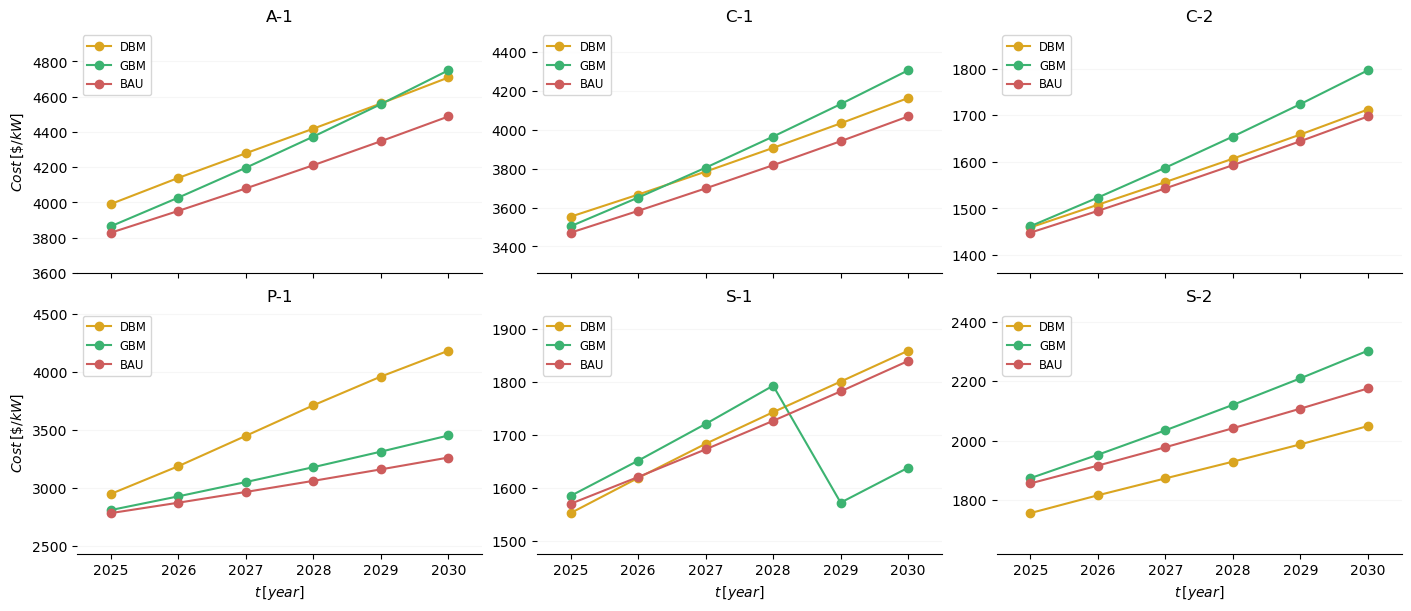

In [34]:
# Plant Cost Index

average_growth_ratio = 1.0323
ratio_between_years = 800 / 468.2  # f(2025)/f(2005)

capital_cost, capital_cost_per_power = calculate_capital_costs(
    df,
    ratio_between_years,
    average_growth_ratio,
    kappa,
    corrected_carbon_emissions,
    power_requirement,
    pressure_ratio,
)

display(capital_cost.round(0).astype(int))
display(capital_cost_per_power.round(0).astype(int))

capital_cost_b, capital_cost_per_power_b = calculate_capital_costs(
    df_b,
    ratio_between_years,
    average_growth_ratio,
    kappa,
    corrected_carbon_emissions_b,
    power_requirement_b,
    pressure_ratio,
)

# Plot

plot_cost = {
    "ylabel": "$Cost \\, [\$/kW]$",
    "leg_loc": "upper left",
    "save_path": "../results/costs/capital_cost.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(capital_cost_per_power, list_of_companies, plot_cost)

### Annual Compression Cost

,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,110202226,84216658,108483561,63014359,62210193,62031615,41690449,45705672,41040263,10650445,9674719,10484345,7364449,7083329,7249597,6257440,5839052,6159852
2026,110202226,82801464,106791699,63014359,62102567,61064198,41690449,45571588,40400218,10650445,8958233,10320836,7364449,7086641,7136535,6257440,5793856,6063786
2027,110202226,81793589,105126223,63014359,62101279,60111868,41690449,45643441,39770154,10650445,8283289,10159877,7364449,7087549,7025237,6257440,5779788,5969218
2028,110202226,81363815,103486721,63014359,62110142,59174390,41690449,45808810,39149916,10650445,7726992,10001428,7364449,7087771,6915674,6257440,5777012,5876125
2029,110202226,81245163,101872788,63014359,62109477,58251532,41690449,45963931,38539351,10650445,7316521,9845450,7364449,7087819,6807821,6257440,5776651,5784483
2030,110202226,81223322,100284025,63014359,62106246,57343067,41690449,46064428,37938309,10650445,7042207,9691905,7364449,7087828,6701649,6257440,5776620,5694271


,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,38614286,29178083,38373085,20368124,20264100,20240890,17275700,17920635,17167800,6609582,6361294,6568311,5705969,5618169,5670346,5347416,5202000,5314033
2026,39861527,29917733,39365102,21026014,20904195,20764149,17833705,18477819,17611632,6823072,6368485,6738130,5890272,5800716,5816954,5520137,5353427,5451431
2027,41149055,30733664,40382765,21705155,21579222,21300935,18409734,19086636,18066938,7043457,6372160,6912340,6080527,5988385,5967353,5698437,5520993,5592382
2028,42478169,31659802,41426738,22406231,22277499,21851599,19004368,19731558,18534016,7270961,6398270,7091054,6276929,6181887,6121641,5882497,5698230,5736978
2029,43850214,32663406,35746503,23129952,22996964,22416499,19618209,20396354,19013170,7505813,6462838,7274389,6479673,6381579,6279919,6072502,5882136,5885312
2030,45266576,33714821,36670598,23877050,23739273,22996004,20251878,21073494,19504712,7748250,6570781,7462464,6688967,6587708,6442289,6268643,6072116,6037482


,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,15142857,11442386,15048269,7987500,7946706,7937604,6774784,7027700,6732471,2591993,2494625,2575808,2237635,2203204,2223665,2097026,2040000,2083935
2026,15631971,11732444,15437295,8245496,8197724,8142803,6993610,7246204,6906522,2675714,2497445,2642404,2309910,2274791,2281158,2164760,2099383,2137816
2027,16136884,12052417,15836378,8511825,8462440,8353308,7219503,7484955,7085074,2762140,2498886,2710722,2384521,2348386,2340138,2234681,2165095,2193091
2028,16658105,12415609,16245780,8786757,8736274,8569254,7452693,7737866,7268242,2851357,2509126,2780805,2461541,2424269,2400644,2306862,2234600,2249795
2029,17196162,12809179,14018236,9070570,9018417,8790784,7693415,7998570,7456145,2943456,2534446,2852702,2541048,2502580,2462713,2381373,2306720,2307966
2030,17751598,13221498,14380627,9363549,9309519,9018041,7941913,8264115,7648907,3038530,2576777,2926456,2623124,2583415,2526388,2458292,2381222,2367640


,S-1 - BAU,S-1 - DBM,S-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,A-1 - BAU,A-1 - DBM,A-1 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,163959369,124837126,161904915,91369983,90420998,90210109,65740933,70654007,64940534,19852020,18530638,19628465,15308053,14904702,15143607,13701882,13081052,13557820
2026,165695724,124451641,161594095,92285869,91204486,89971150,66517764,71295611,64918372,20149231,17824163,19701370,15564632,15162148,15234648,13942337,13246666,13653033
2027,167488164,124579671,161345366,93231339,92142941,89766110,67319686,72215032,64922166,20456042,17154336,19782938,15829497,15424320,15332729,14190559,13465876,13754691
2028,169338500,125439226,161159239,94207348,93123914,89595243,68147511,73278234,64952173,20772762,16634388,19873287,16102918,15693927,15437959,14446799,13709841,13862897
2029,171248602,126717748,151637528,95214881,94124857,89458815,69002074,74358855,65008666,21099713,16313805,19972540,16385171,15971978,15550452,14711315,13965508,13977761
2030,173220400,128159642,151335250,96254958,95155038,89357112,69884239,75402038,65091927,21437225,16189764,20080825,16676540,16258951,15670325,14984376,14229958,14099393


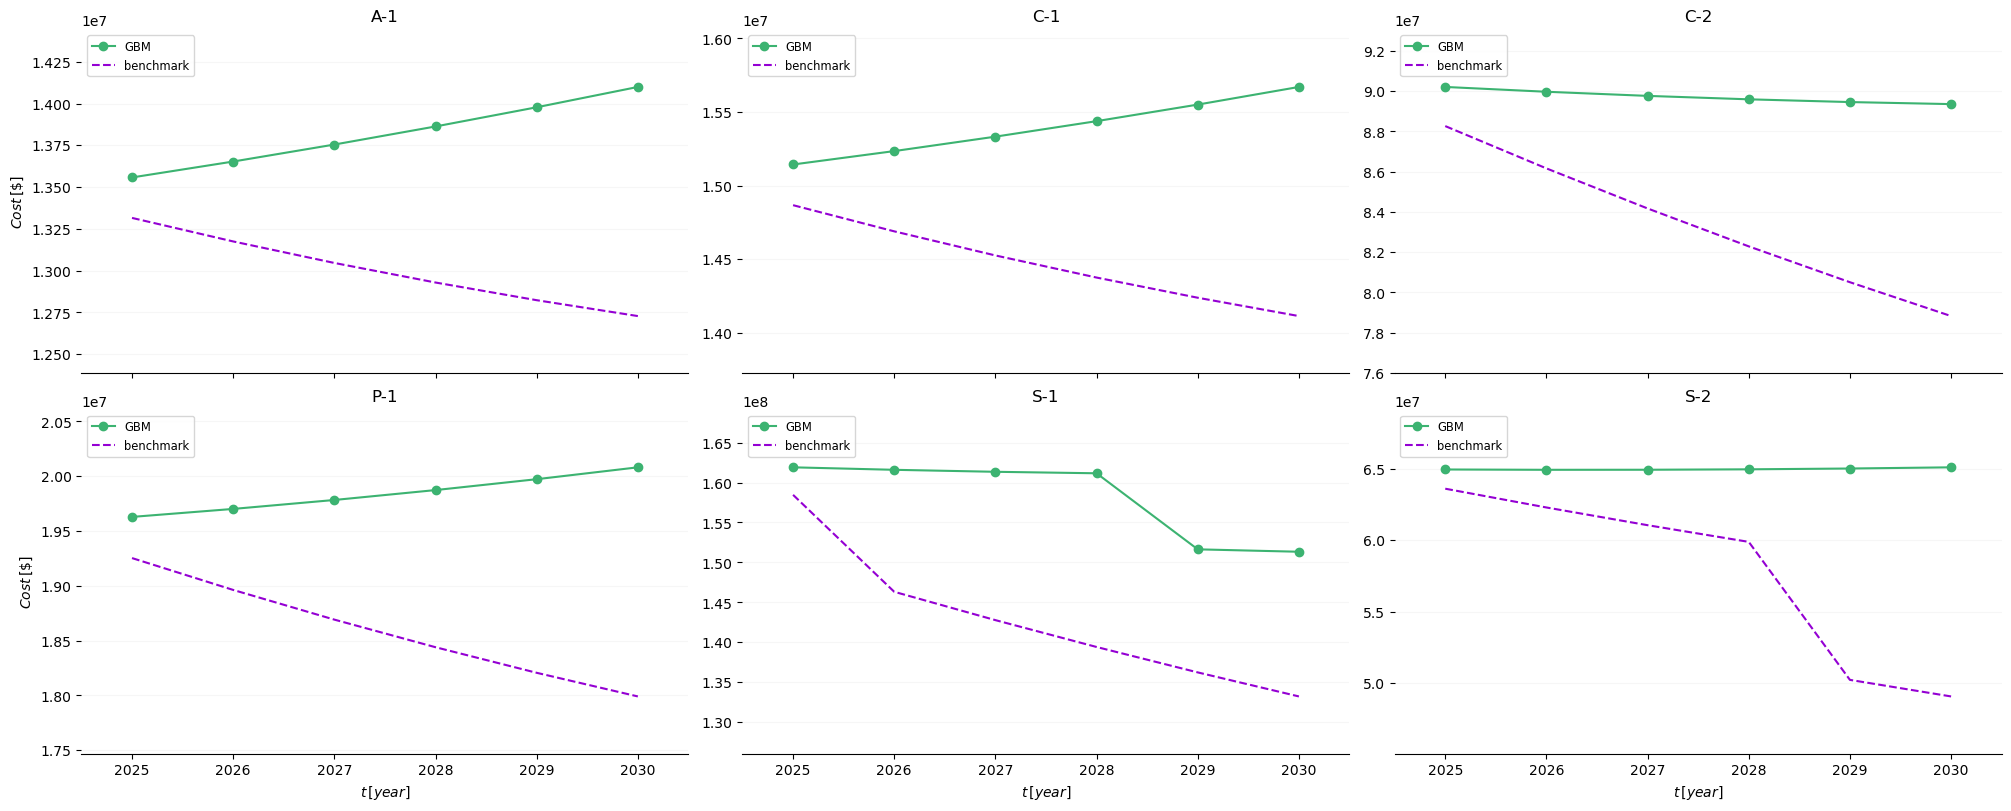

In [35]:
# Annual Energy Cost ($)

energy_cost = power_requirement * energy_price * capacity_factor * 24 * 365
energy_cost_b = power_requirement_b * energy_price * capacity_factor * 24 * 365

display(energy_cost.round(0).astype(int))

# Annual Capital Cost ($)

corrected_cost_of_capital = capital_cost * capital_recovery_factor
corrected_cost_of_capital_b = capital_cost_b * capital_recovery_factor

display(corrected_cost_of_capital.round(0).astype(int))

# Annual O&M Cost ($)

oem_cost = capital_cost * oem_maintenance_factor
oem_cost_b = capital_cost_b * oem_maintenance_factor

display(oem_cost.round(0).astype(int))

# Total Annual Cost ($)

total_cost = corrected_cost_of_capital + oem_cost + energy_cost
total_cost_b = corrected_cost_of_capital_b + oem_cost_b + energy_cost_b

display(total_cost.round(0).astype(int))

# Plot

fig, axs = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    column_name = company_name + " - GBM"

    years = total_cost.index.values
    data = total_cost.loc[:, column_name].values
    data_b = total_cost_b.loc[:, column_name].values

    ax = axs[company_id]
    ax.plot(years, data, "-o", color=COLORS["GBM"], label="GBM")
    ax.plot(years, data_b, "--", color=COLORS["Benchmark"], label="benchmark")

    config_plot(
        ax,
        np.concatenate((data, data_b)),
        [years[0]-0.5, years[-1]+0.5],
        company_name,
        "upper left",
        1
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Cost \\, [\$]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

In [36]:
# Transformation of Dataframes

corrected_cost_of_capital = transform_dataframe(corrected_cost_of_capital, "Cap")
oem_cost = transform_dataframe(oem_cost, "OEM")
energy_cost = transform_dataframe(energy_cost, "Power")

# Merging Dataframes

annual_cost = pd.merge(corrected_cost_of_capital, oem_cost, on=["Years", "Company", "Model"], how="outer")
annual_cost = pd.merge(
    annual_cost, energy_cost, on=["Years", "Company", "Model"], how="outer"
)
annual_cost = annual_cost.loc[:, ["Company", "Model", "Years", "Cap", "OEM", "Power"]]
display(annual_cost)

,Company,Model,Years,Cap,OEM,Power
0,A-1,BAU,2025,5.347416e+06,2.097026e+06,6.257440e+06
1,A-1,DBM,2025,5.202000e+06,2.040000e+06,5.839052e+06
2,A-1,GBM,2025,5.314033e+06,2.083935e+06,6.159852e+06
3,C-1,BAU,2025,5.705969e+06,2.237635e+06,7.364449e+06
4,C-1,DBM,2025,5.618169e+06,2.203204e+06,7.083329e+06
...,...,...,...,...,...,...
103,S-1,DBM,2030,3.371482e+07,1.322150e+07,8.122332e+07
104,S-1,GBM,2030,3.667060e+07,1.438063e+07,1.002840e+08
105,S-2,BAU,2030,2.025188e+07,7.941913e+06,4.169045e+07
106,S-2,DBM,2030,2.107349e+07,8.264115e+06,4.606443e+07


In [37]:
def add_labels(ax, rects, total_val):
    for rect in rects:
        # Get the height and width of the bar rectangle
        height = rect.get_height()
        width = rect.get_width()
        # Get the x and y position of the bottom left corner of the rectangle
        x_pos = rect.get_x()
        y_pos = rect.get_y()

        # Calculate the center position for the label
        center_x = x_pos + width / 2
        center_y = y_pos + height / 2

        # Add the label
        ax.text(
            center_x,
            center_y + 0.02 * total_val,
            f"{height/1e6:.1f}",
            ha="center",
            va="center",
            color="white",
            fontsize=8,
        )


def add_rel_labels(ax, rects, value, total_val):
    for rect in rects:
        # Get the height and width of the bar rectangle
        height = rect.get_height()
        width = rect.get_width()
        # Get the x and y position of the bottom left corner of the rectangle
        x_pos = rect.get_x()
        y_pos = rect.get_y()

        # Calculate the center position for the label
        center_x = x_pos + width / 2
        center_y = y_pos + height / 2

        # Add the label
        ax.text(
            center_x,
            center_y - 0.02 * total_val,
            f"({value:.0f}%)",
            ha="center",
            va="center",
            color="white",
            fontsize=8,
        )

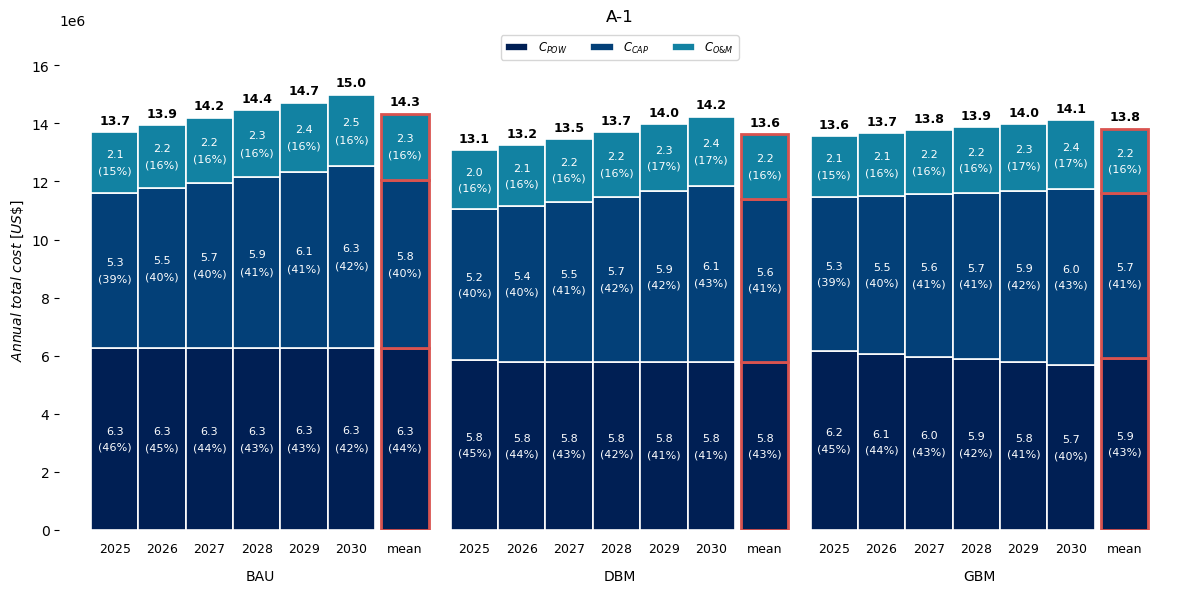

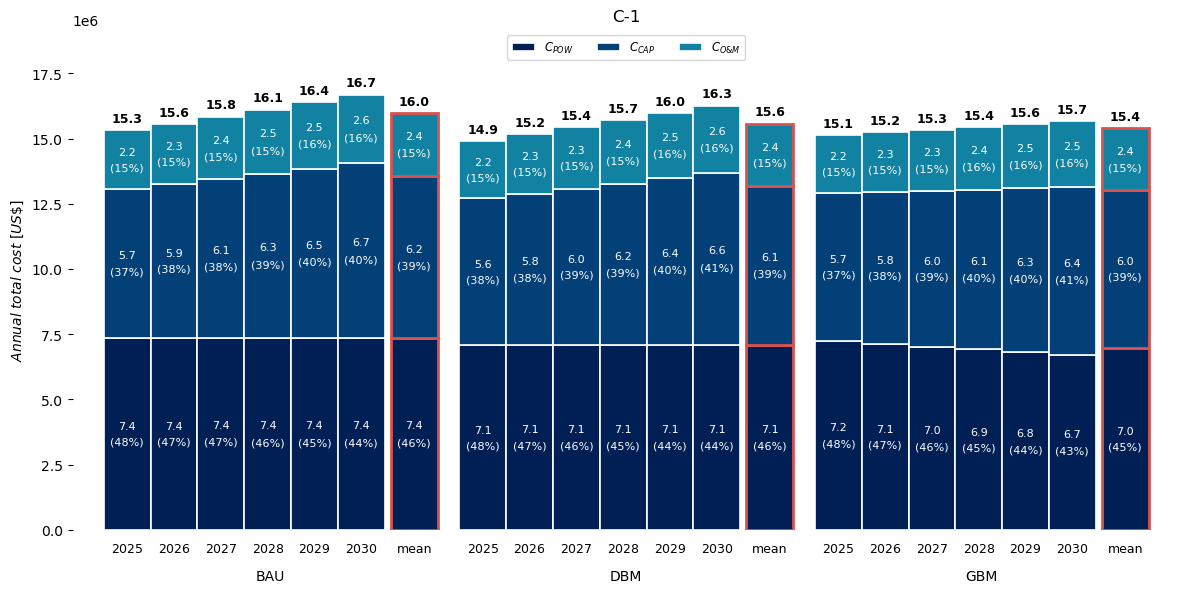

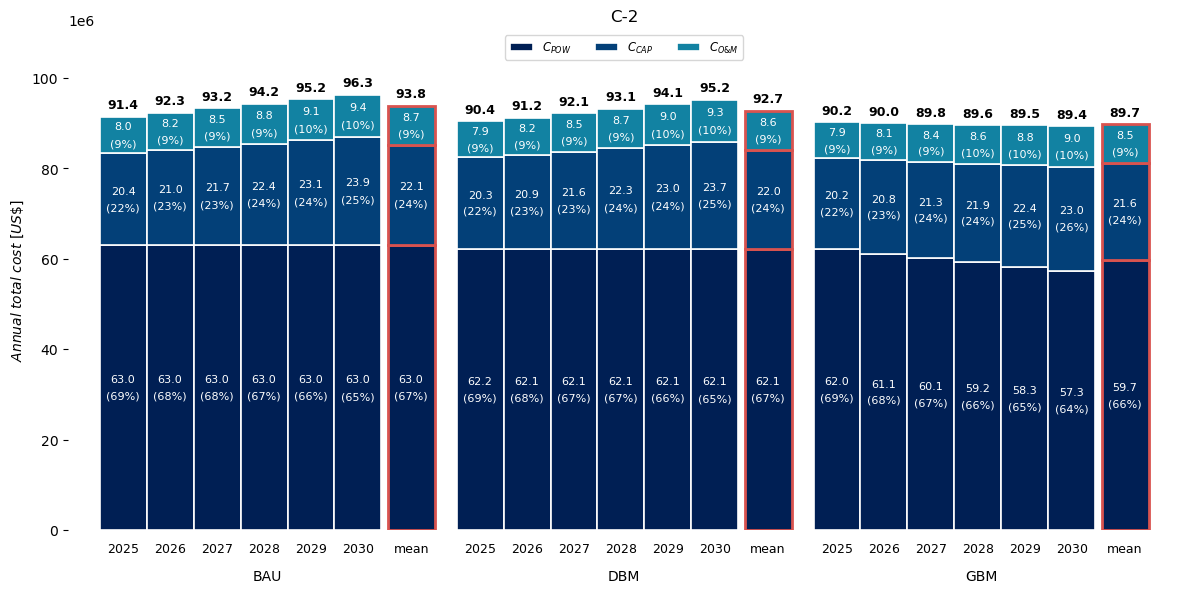

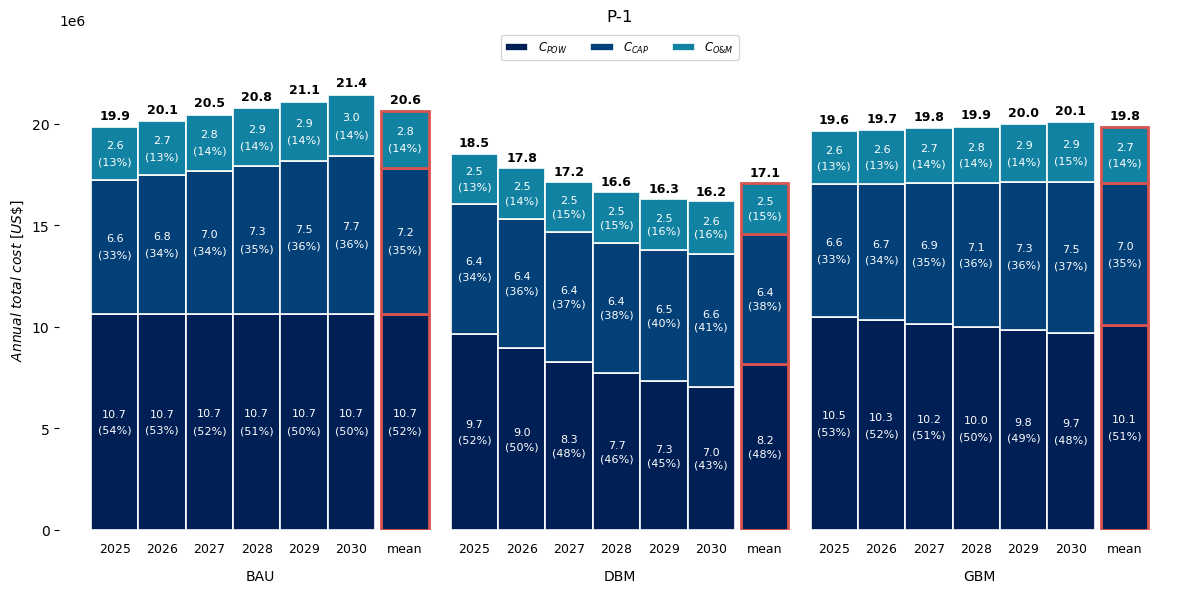

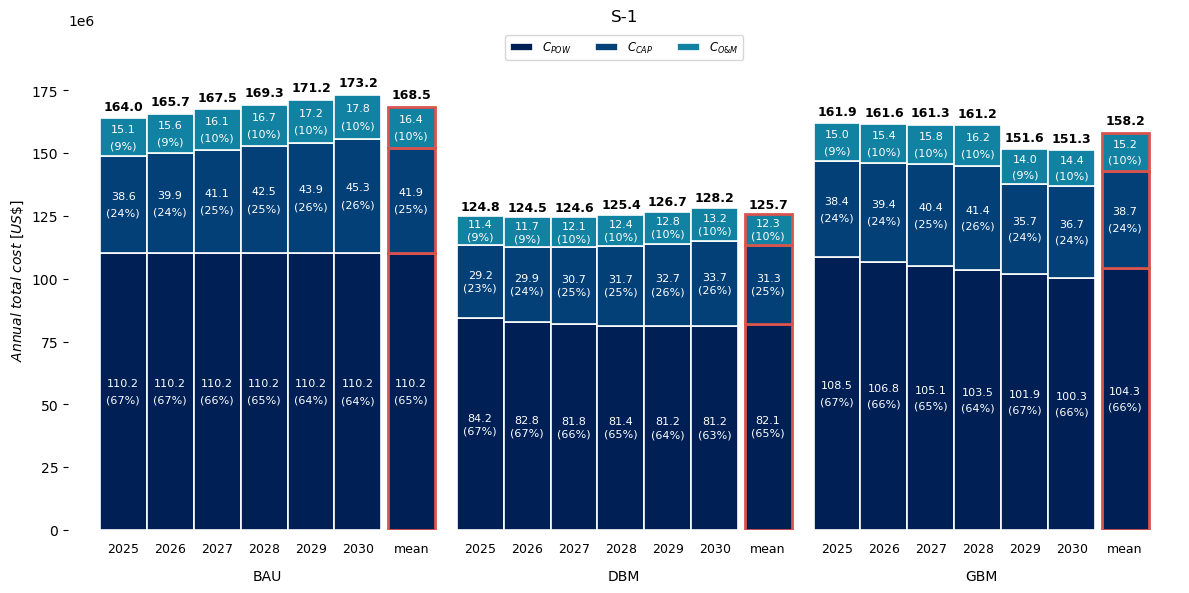

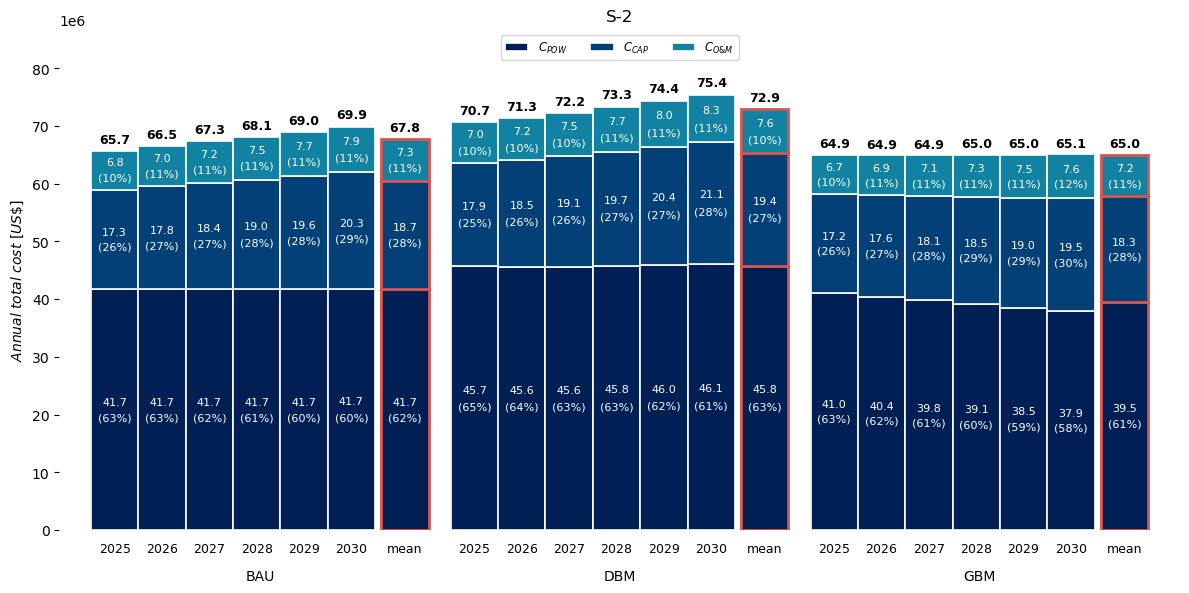

In [ ]:
# Layout Parameters

scenarios = ["BAU", "DBM", "GBM"]
years = annual_cost.Years.unique()

n_years = len(years)
bar_width = 0.75  # Width of each bar (year) within the group
space_between_scenarios = 0.35
space_to_average_bar = 0.1

formatter = ScalarFormatter(useMathText=False)
formatter.set_powerlimits((6, 6))

# Company positions on the X axis
group_pos = np.arange(len(scenarios)) * (
    n_years * bar_width + space_between_scenarios + (space_to_average_bar + bar_width)
)

# Soft colors and slice labels
total_cost_colors = ["#001f54", "#034078", "#1282a2"]
labels = ["$C_{POW}$", "$C_{CAP}$", r"$C_{O&M}$"]

for company_name in list_of_companies:
    annual_cost_filtered = annual_cost[annual_cost["Company"] == company_name]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.yaxis.set_major_formatter(formatter)

    for i, scen in enumerate(scenarios):
        subset = annual_cost_filtered[annual_cost_filtered["Model"] == scen]
        average_subset = np.mean(subset[["Power", "Cap", "OEM"]].values, axis=0)

        for j, year in enumerate(years):
            vals = subset[subset["Years"] == year][["Power", "Cap", "OEM"]].values[0]
            vals_perc = vals * 100 / sum(vals)

            x = group_pos[i] + j * bar_width
            bottom = 0.0

            for k, val in enumerate(vals):
                bar_obj = ax.bar(
                    x,
                    val,
                    width=bar_width,
                    bottom=bottom,
                    color=total_cost_colors[k],
                    edgecolor="white",
                    linewidth=1.2,
                    label=labels[k] if (i == 0 and j == 0) else None,
                    zorder=2,
                )
                bottom += val

                # Label the "size" of the bar
                add_labels(ax, bar_obj, total_val=sum(vals))
                add_rel_labels(ax, bar_obj, vals_perc[k], total_val=sum(vals))

            # Total label over each bar
            ax.text(
                x,
                1.02 * sum(vals),
                f"{sum(vals)/1e6:.1f}",
                ha="center",
                fontsize=9,
                weight="bold",
            )

            # Year label under each bar
            ax.text(
                x,
                -0.045,
                year,
                ha="center",
                transform=ax.get_xaxis_transform(),
                fontsize=9,
            )

        # Average Bar

        x = group_pos[i] + n_years * bar_width + space_to_average_bar
        bottom = 0.0

        for k, val in enumerate(average_subset):
            bar_obj = ax.bar(
                x,
                val,
                width=bar_width,
                bottom=bottom,
                color=total_cost_colors[k],
                edgecolor="#d9534f",
                linewidth=2,
                zorder=2,
            )
            bottom += val

            # Label the "size" of the bar
            add_labels(ax, bar_obj, total_val=sum(average_subset))
            add_rel_labels(
                ax,
                bar_obj,
                val * 100 / sum(average_subset),
                total_val=sum(average_subset),
            )

        # Total label over each bar
        ax.text(
            x,
            1.02 * sum(average_subset),
            f"{sum(average_subset)/1e6:.1f}",
            ha="center",
            fontsize=9,
            weight="bold",
        )

        # Year label under each bar
        ax.text(
            x,
            -0.045,
            "mean",
            ha="center",
            transform=ax.get_xaxis_transform(),
            fontsize=9,
        )

    # Scenario label centered under each group
    for i, scen in enumerate(scenarios):
        xpos = (
            group_pos[i]
            + (n_years - 1) * bar_width / 2
            + (space_to_average_bar + bar_width) / 2
        )
        ypos = -0.1
        ax.text(
            xpos,
            ypos,
            scen,
            ha="center",
            fontsize=10,
            transform=ax.get_xaxis_transform(),
        )

    ax.set_ylabel("$Annual \\ total \\ cost \\ [US\$]$")
    ax.set_ylim(
        0, annual_cost_filtered[["Power", "Cap", "OEM"]].sum(axis=1).max() * 1.15
    )

    ax.set_xticks([])

    ax.margins(x=0.03)

    # ax.grid(axis="y", alpha=0.1, zorder=0)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(title="", loc="upper center", fontsize="small", ncol=3)
    ax.set_title(company_name)

    plt.tight_layout()
    plt.savefig(
        f"../results/costs/total_cost/anual_cost-{company_name}.png",
        dpi=900,
        bbox_inches="tight",
    )

### Sensitivity Analysis

Assessing the impact of energy costs on total annual costs.

In [39]:
total_cost = transform_dataframe(total_cost, "Total Cost")

In [42]:
rates_of_variation = np.arange(-15, 20, 5) / 100

corrected_cost_of_capital = capital_cost * capital_recovery_factor
oem_cost = capital_cost * oem_maintenance_factor

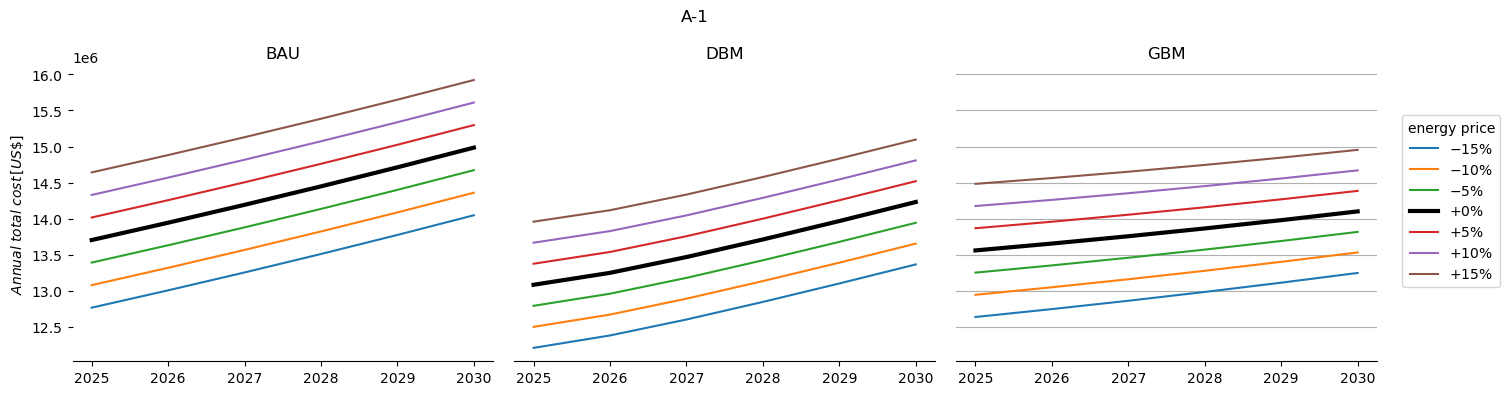

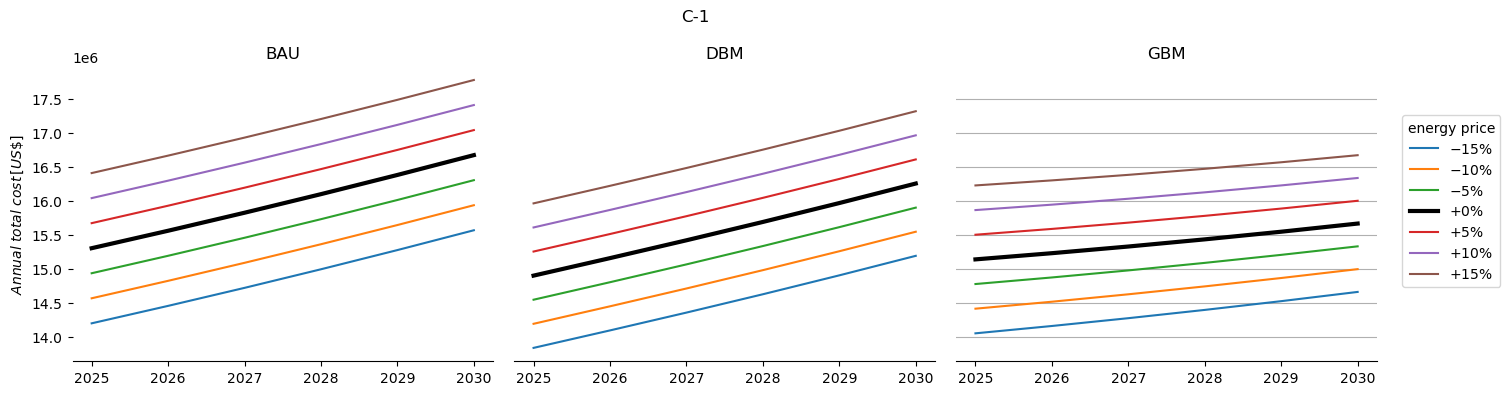

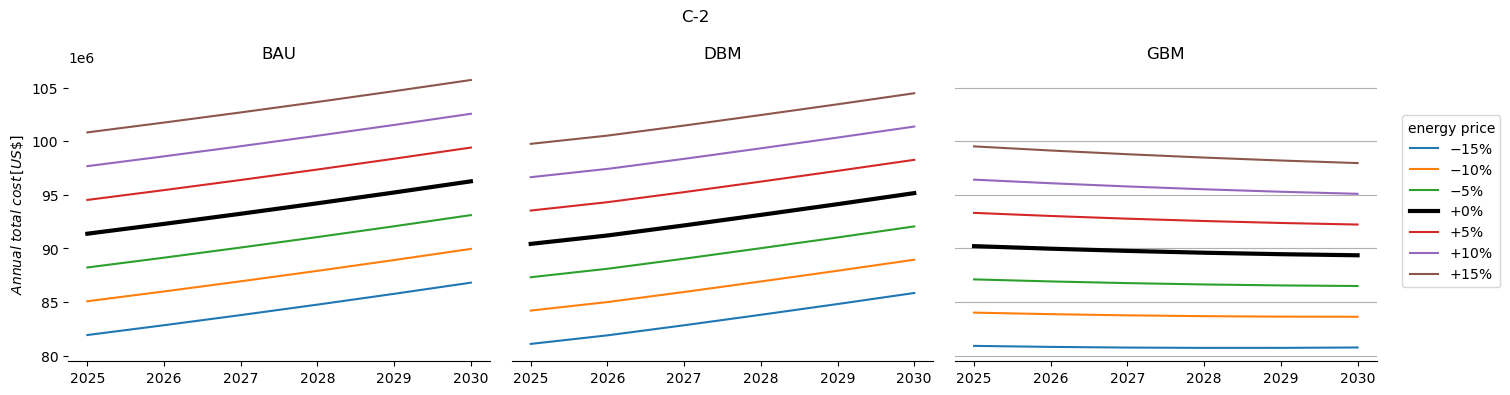

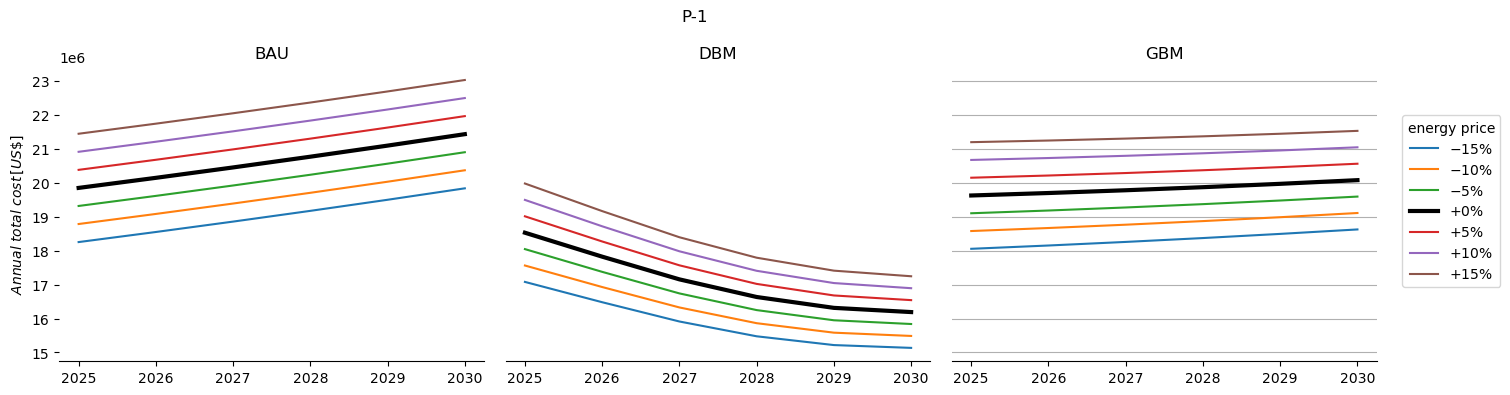

In [ ]:
for company_name in list_of_companies:
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

    for variation in rates_of_variation:
        energy_cost = (
            power_requirement
            * (energy_price * (variation + 1))
            * capacity_factor
            * 24
            * 365
        )
        annual_total_cost = corrected_cost_of_capital + oem_cost + energy_cost
        transformed_total_cost = transform_dataframe(annual_total_cost, "Total Cost")
        total_cost_filtered = transformed_total_cost[
            transformed_total_cost["Company"] == company_name
        ]

        # Line
        if variation == 0:
            line_color = "black"
            line_width = 3
        else:
            line_color = None
            line_width = 1.5

        # Legend
        rate_legend = int(variation * 100)
        if rate_legend < 0:
            rate_legend = f"${int(variation * 100)}\%$"
        else:
            rate_legend = f"$+{int(variation * 100)}\%$"

        for i, scen in enumerate(scenarios):
            subset = total_cost_filtered[total_cost_filtered["Model"] == scen]

            # Plots
            ax = axs[i]
            ax.yaxis.set_major_formatter(formatter)

            ax.plot(
                subset["Years"],
                subset["Total Cost"],
                label=rate_legend,
                color=line_color,
                linewidth=line_width,
                zorder=10,
            )

            ax.set_title(scen)
            if i == 0:
                ax.set_ylabel("$Annual \\ total \\ cost \\, [US\$]$")
            else:
                ax.tick_params(axis="y", which="both", length=0)

            ax.spines["left"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            plt.grid(axis="y")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
        title="energy price",
    )

    fig.suptitle(company_name)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1)

    fig.savefig(
        f"../results/costs/sensitivity_analysis/{company_name}.png",
        dpi=600,
        bbox_inches="tight",
    )